In [1]:
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude
from functions import *


Note: you may need to restart the kernel to use updated packages.


### *1.1 Introductory exercise*

This exercise serves to refresh concepts from the basic image analysis curriculum that will be useful at a later stage in the course.

#### *1.1.1 Image convolution*

Image convolution is a central tool in image analysis. In this exercise, you will investigate properties related to convolution using a Gaussian kernel and its derivatives. For further reading material regarding convolution and filtering, refer to [1], Chapter 5. [2]

For continuous functions $f$ and $g$, convolution is defined as

$$
(f * g)(x) = \int_{-\infty}^{\infty} f(x - \tau) g(\tau) d\tau. \tag{1.1}
$$

Convolution is commutative, but we sometimes distinguish between the signal and the kernel, and we say that the signal is convolved with the kernel. In discrete settings, the equation becomes

$$
(f * g)(x) = \sum_{i=-l}^{l} f(x - i) g(i). \tag{1.2}
$$

In 2D, a convolution with a square kernel is given by

$$
(f * g)(x, y) = \sum_{i=-l}^{l} \sum_{j=-l}^{l} f(x - i, y - j) g(i, j). \tag{1.3}
$$

In image analysis, a Gaussian kernel is often used for image smoothing. The 1D Gaussian with variance $t$ is defined by

$$
g(x; t) = \frac{1}{\sqrt{2t\pi}} e^{-\frac{x^2}{2t}}. \tag{1.4}
$$

Sometimes we parametrize the Gaussian with the standard deviation $\sigma$, where $t = \sigma^2$. The 2D isotropic Gaussian is given by

$$
g(x, y; t) = \frac{1}{2t\pi} e^{-\frac{x^2 + y^2}{2t}}. \tag{1.5}
$$



The Gaussian is separable ([3] Section 5.3.1), which means that convolution with two orthogonal 1D Gaussians yields the same result as convolving with a 2D Gaussian of the same variance. This can significantly speed up convolutions, especially for large kernels.

Another property of the Gaussian convolution is the so-called *semi-group structure*, stating that convolving an image $I$ with a single large Gaussian is equivalent to convolving with several small ones:

$$
g(x, y; t_1 + t_2) * I(x, y) = g(x, y; t_1) * g(x, y; t_2) * I(x, y). \tag{1.6}
$$


On the right part of the equation, the order of convolution does not matter, as convolution is associative.

For an image $I$, we often need to know a local change in intensity values. This can be achieved by taking the spatial derivative. Since the image is a discretely sampled signal, we approximate the derivative, often by computing the difference between neighboring pixels.

When taking the derivative, it is often desirable to remove the noise by smoothing, e.g., using a Gaussian. It turns out that instead of convolving with a Gaussian and then taking the derivative, we can convolve with the derivative of the Gaussian:

$$
\frac{\partial}{\partial x} (I * g) = \frac{\partial I}{\partial x} * g = I * \frac{\partial g}{\partial x}. \tag{1.7}
$$


Since we can compute the derivative of the Gaussian analytically, we get an efficient and elegant approach to computing a smoothed image derivative. The analytic expression for the 1D Gaussian derivative is:

$$
\frac{d}{dx} g(x) = \frac{-x}{\sigma^3 \sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}} = \frac{-x}{t} g(x). \tag{1.8}
$$


The semi-group structure also holds for image derivatives, such that:

$$
\frac{\partial}{\partial x} g(x, y; t_1 + t_2) * I(x, y) = \frac{\partial}{\partial x} g(x, y; t_1) * (g(x, y; t_2) * I(x, y)). \tag{1.9}
$$

This implies that convolving with a large Gaussian derivative yields the same result as convolving with a smaller Gaussian and a smaller Gaussian derivative.

### *Exercise overview*  
We will experimentally test the statements made in the text above. You may use an existing implementation of convolution, e.g., `scipy.ndimage.convolve`. However, refrain from using an existing implementation of the Gaussian filtering or functions returning the Gaussian kernel and its derivative.

### *Data*  
For this exercise, you may use any grayscale image. We have provided an X-ray CT image of fibres `fibres_xcth.png`, shown in Figure **1.1** and Figure **1.2**.

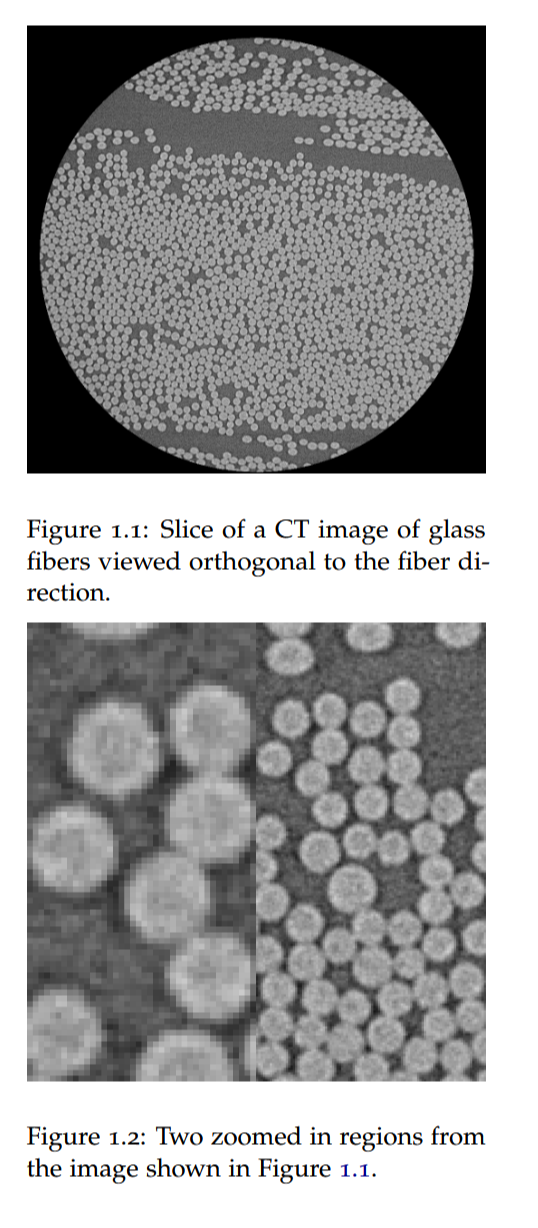


### Tasks

#### 1. **Create Gaussian Kernel**  
   Gaussian kernels are usually truncated at a value between 3 and 5 times $\sigma$. You can create a kernel as follows:

   (a) Compute an integer kernel radius $s$ approximately equal to $4\sigma$.

   (b) Create an array $x$ with integer values centered around 0, that is  
   $x = [-r, \ldots, 0, \ldots, r]$.

   (c) Compute the kernel values using equation 1.4. You may initially compute the values without the normalization term and normalize the kernel to ensure the sum of all values equals 1.

   Verify that your kernel is correct by plotting $x$ against $g$ as shown in **Figure 1.4**. A kernel with the derivative of the Gaussian can be created similarly, and you can see the plot in **Figure 1.5**.


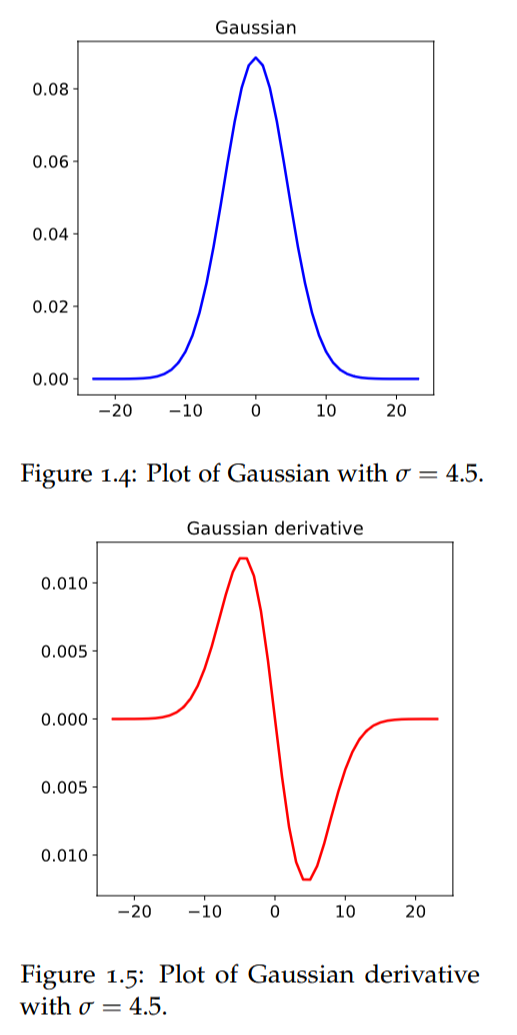


Sigma: 5.0
Sigma: 5.0


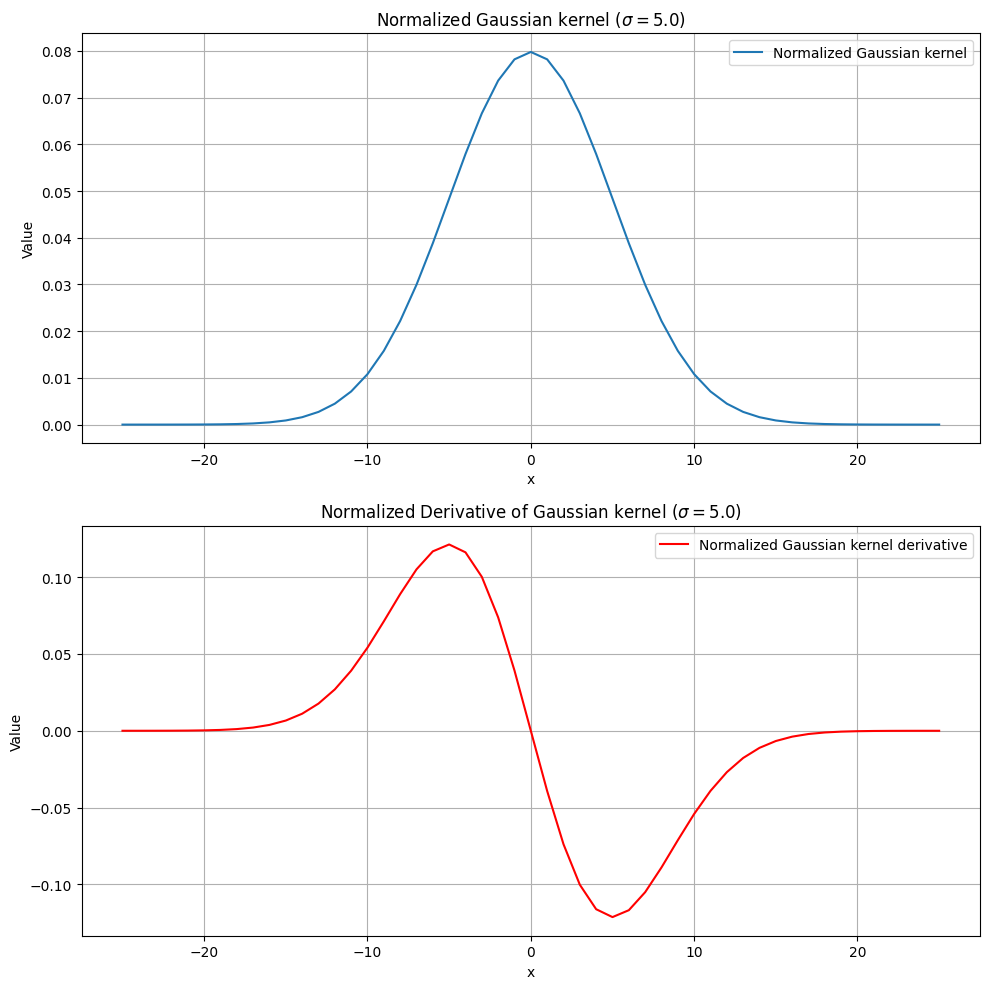

In [2]:
# standard deviation of the Gaussian kernel nad the number of standard deviations to consider
t = 25.
N = 5.

# create the 1D kernel
kernel_1D, x = create_1D_kernel_2(t, N, return_x=True)
kernel_1D_grad = create_1D_kernel_grad_2(t, N)
assert np.allclose(kernel_1D.sum(), 1), "Kernel is not normalized"


# Plot the kernels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot normalized Gaussian kernel
ax[0].plot(x, kernel_1D, label="Normalized Gaussian kernel")
ax[0].set_title(rf"Normalized Gaussian kernel ($\sigma = {np.sqrt(t)}$)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Value")
ax[0].grid()
ax[0].legend()

# Plot normalized derivative of Gaussian kernel
ax[1].plot(x, kernel_1D_grad, label="Normalized Gaussian kernel derivative", color="red")
ax[1].set_title(rf"Normalized Derivative of Gaussian kernel ($\sigma = {np.sqrt(t)}$)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Value")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

2. **Experimentally Verify the Separability of the Gaussian Kernel**  
   For this, convolve the test image with a 2D Gaussian kernel. Note that you can get a 2D Gaussian kernel as the *outer product* of two 1D kernels. Then, convolve the same test image with two orthogonal 1D kernels. You should get the same result, i.e., after subtracting the two images, the image difference should be small.  

   **Tip**: Use the `'bwr'` colormap to visualize the difference image. Look at the sketch in **Figure 1.6** to understand what you are testing.

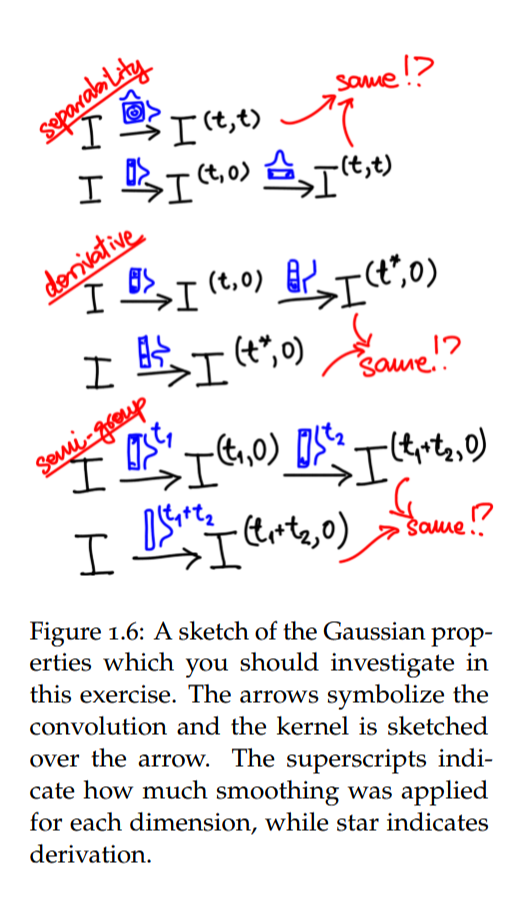

In [3]:
image = get_gray_image("data/fibres_xcth.png")

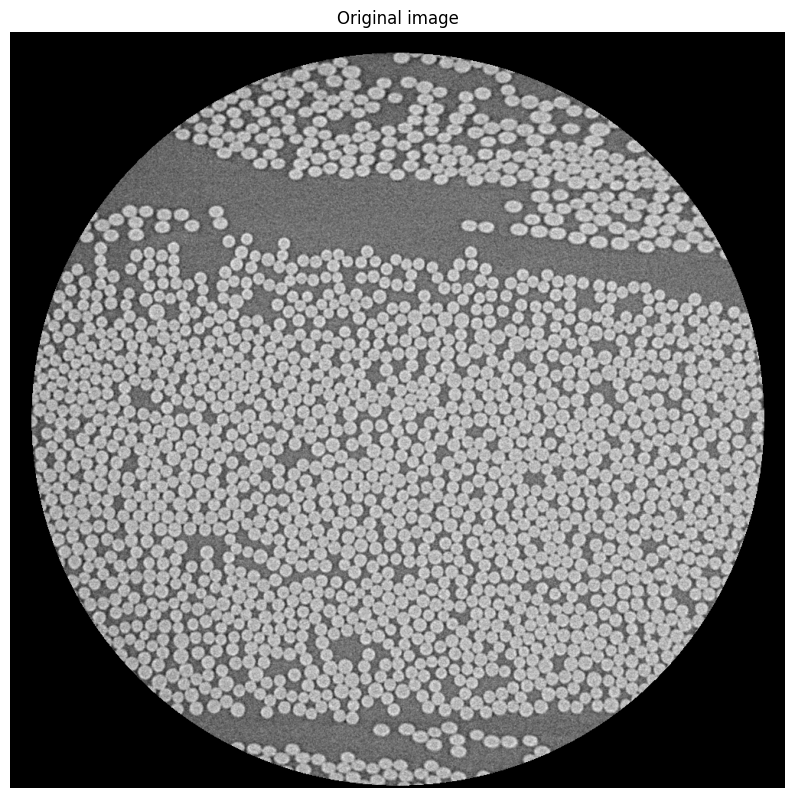

In [4]:
# plot the image 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image, cmap="gray")
ax.set_title("Original image")
ax.axis("off")
plt.show()


Shape of the 2D kernel: (51, 51)


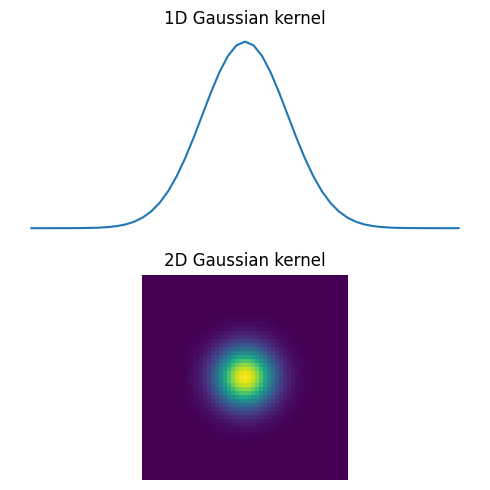

In [5]:
# create 2D kernel by outer product of the 1D kernels
kernel_2d = np.outer(kernel_1D, kernel_1D)
print(f"Shape of the 2D kernel: {kernel_2d.shape}")

# visualize the kernel 
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(kernel_1D)
ax[0].set_title("1D Gaussian kernel")
ax[0].axis('off')
ax[1].imshow(kernel_2d, cmap='viridis')
ax[1].set_title("2D Gaussian kernel")
ax[1].axis('off')
plt.tight_layout()
plt.show()

Shape of the original image: (988, 1013)
Shape of the blurred image: (988, 1013)


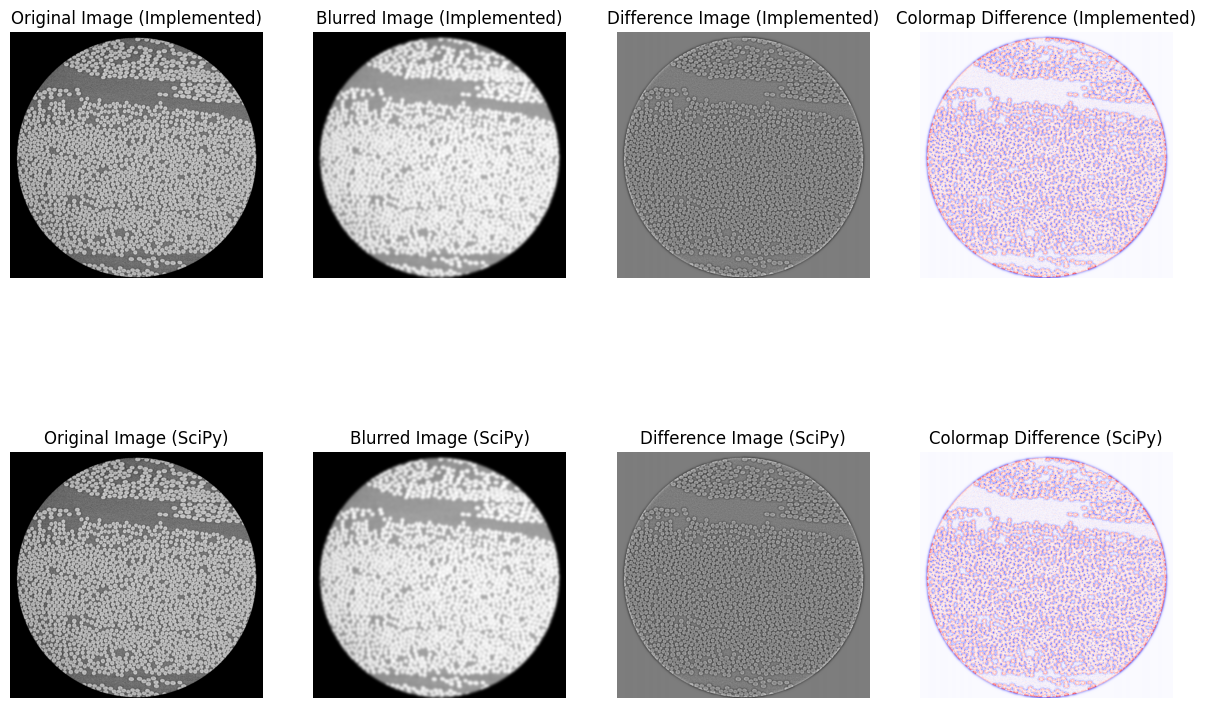

Absolute average difference between the two methods: 4.981084184000381e-16


In [6]:
SIGMA = np.sqrt(t)

# applying the 2D gaussian kernel to the image
image_blurred = convolve(image, kernel_2d)
print(f"Shape of the original image: {image.shape}")
print(f"Shape of the blurred image: {image_blurred.shape}")

difference_image = image - image_blurred

# scipy 2d kernel filter 

image_blurred_scipy = gaussian_filter(image, SIGMA, truncate=5.0)
difference_image_scipy = image - image_blurred_scipy
# smoothing function that takes image and kernel as input


fig, ax = plt.subplots(2, 4, figsize=(15, 10))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title("Original Image (Implemented)")
ax[0, 0].axis('off')
ax[0, 1].imshow(image_blurred, cmap='gray')
ax[0, 1].set_title("Blurred Image (Implemented)")
ax[0, 1].axis('off')
ax[0, 2].imshow(difference_image, cmap='gray')
ax[0, 2].set_title("Difference Image (Implemented)")
ax[0, 2].axis('off')
ax[0, 3].imshow(difference_image, cmap='bwr')
ax[0, 3].set_title("Colormap Difference (Implemented)")
ax[0, 3].axis('off')
ax[1, 0].imshow(image, cmap='gray')
ax[1, 0].set_title("Original Image (SciPy)")
ax[1, 0].axis('off')
ax[1, 1].imshow(image_blurred_scipy, cmap='gray')
ax[1, 1].set_title("Blurred Image (SciPy)")
ax[1, 1].axis('off')
ax[1, 2].imshow(difference_image_scipy, cmap='gray')
ax[1, 2].set_title("Difference Image (SciPy)")
ax[1, 2].axis('off')
ax[1, 3].imshow(difference_image_scipy, cmap='bwr')
ax[1, 3].set_title("Colormap Difference (SciPy)")
ax[1, 3].axis('off')

#plt.savefig("output/2d_gaussian_blur.png", dpi=300, bbox_inches='tight')
plt.show()


#print absolute average differente between image bluered and image blurred scipy
print(f"Absolute average difference between the two methods: {np.abs(difference_image - difference_image_scipy).mean()}")

# check if the two methods are equal
assert np.allclose(image_blurred, image_blurred_scipy), "The two methods are not equal"
assert np.allclose(difference_image, difference_image_scipy), "The two methods are not equal"

Shape of the image after column-wise convolution (SciPy): (988, 1013)
Shape of the image after row-wise convolution (SciPy): (988, 1013)


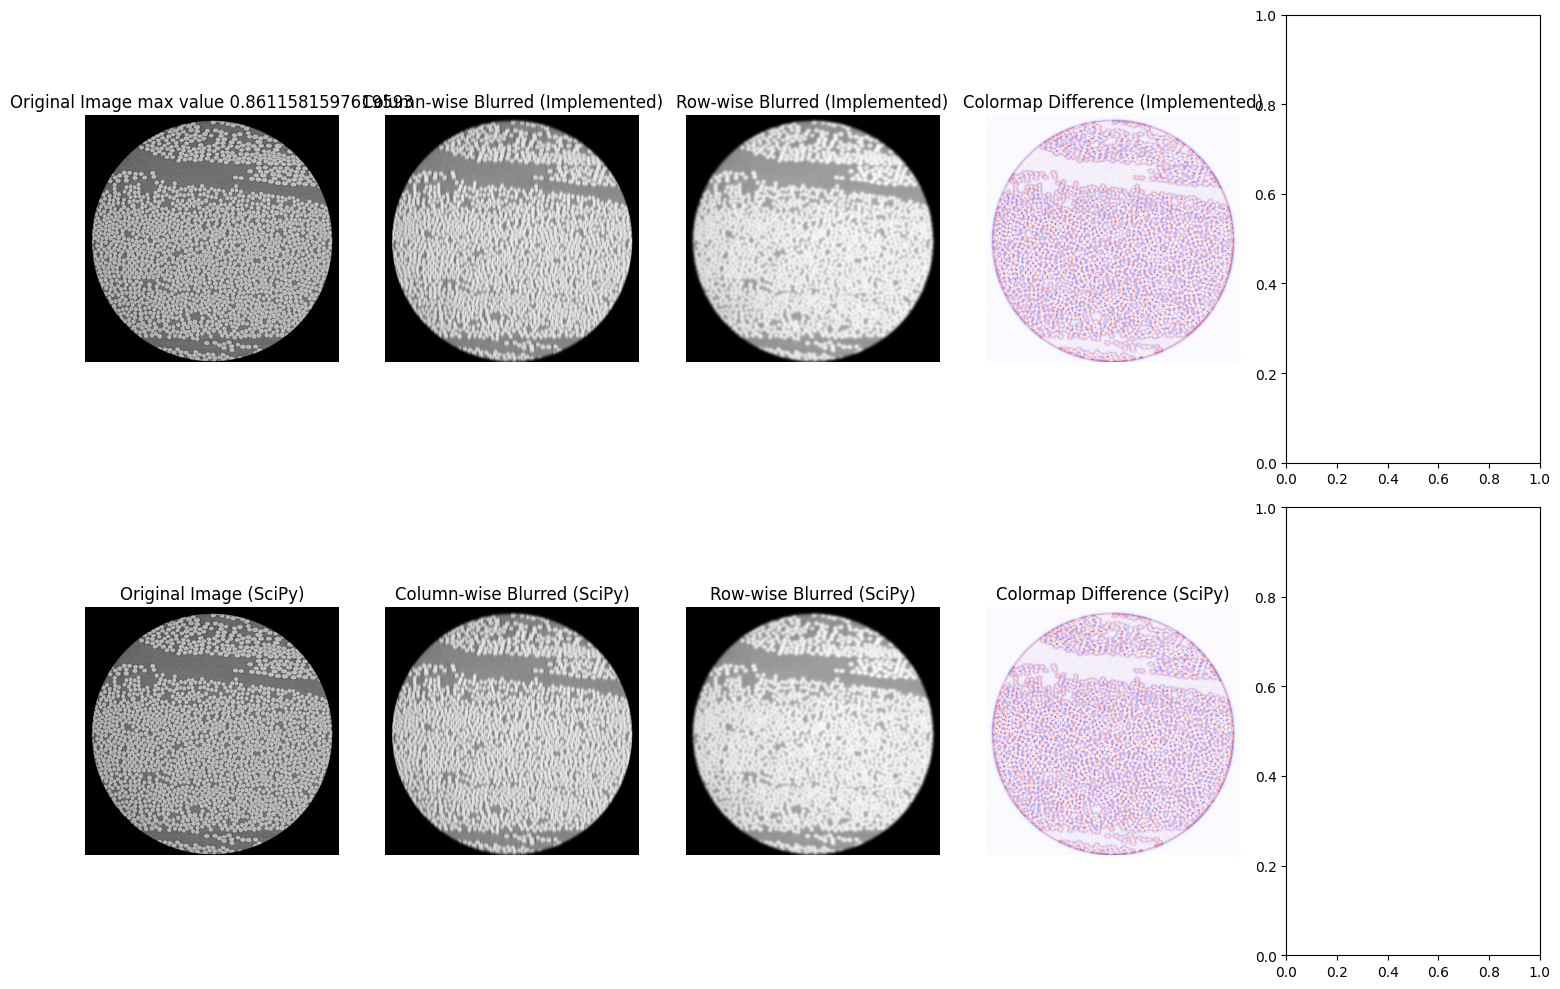

Absolute average difference between the two methods: 7.540137672259236e-17


In [7]:
image_columns = convolve_columns(image, kernel_1D)

image_rows = convolve_rows(image_columns, kernel_1D)

difference = image - image_rows


# convolve column wise
image_columns_scipy = gaussian_filter1d(image, SIGMA, axis=0, truncate=5.0)
print(f"Shape of the image after column-wise convolution (SciPy): {image_columns_scipy.shape}")

# then convolve along the rows
image_rows_scipy = gaussian_filter1d(image_columns_scipy, SIGMA, axis=1, truncate=5.0)
print(f"Shape of the image after row-wise convolution (SciPy): {image_rows_scipy.shape}")

# take a difference of origo and the blurred image
difference_scipy = image - image_rows_scipy



fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title(f"Original Image max value {image.max()}")
ax[0, 0].axis('off')
ax[0, 1].imshow(image_columns, cmap='gray')
ax[0, 1].set_title("Column-wise Blurred (Implemented)")
ax[0, 1].axis('off')
ax[0, 2].imshow(image_rows, cmap='gray')
ax[0, 2].set_title("Row-wise Blurred (Implemented)")
ax[0, 2].axis('off')
ax[0, 3].imshow(difference, cmap='bwr')
ax[0, 3].set_title("Colormap Difference (Implemented)")
ax[0, 3].axis('off')
ax[1, 0].imshow(image, cmap='gray')
ax[1, 0].set_title("Original Image (SciPy)")
ax[1, 0].axis('off')
ax[1, 1].imshow(image_columns_scipy, cmap='gray')
ax[1, 1].set_title("Column-wise Blurred (SciPy)")
ax[1, 1].axis('off')
ax[1, 2].imshow(image_rows_scipy, cmap='gray')
ax[1, 2].set_title("Row-wise Blurred (SciPy)")
ax[1, 2].axis('off')
ax[1, 3].imshow(difference_scipy, cmap='bwr')
ax[1, 3].set_title("Colormap Difference (SciPy)")
ax[1, 3].axis('off')

plt.tight_layout()
plt.show()


# check if the two methods are equal
assert np.allclose(image_rows, image_rows_scipy), "The two methods are not equal"
assert np.allclose(image_columns, image_columns_scipy), "The two methods are not equal"

# print absolute average difference 
print(f"Absolute average difference between the two methods: {np.abs(difference - difference_scipy).mean()}")

3. **Experimentally Verify 1.7**  
   It is enough to test the 1D case. That is, obtain one result by convolving the image with a 1D Gaussian, and take the derivative in the same direction. You can compute the derivative by convolving the image with the kernel $[0.5, 0, -0.5]$.  

   Obtain the second result by convolving the image with the derivative of the Gaussian. Verify that the difference between the two results is small.  

   **Hint**: Compute the average absolute difference between the two images.


##### Convonving the Image with a 1D Gaussian Kernel and then with the Derivative Filter in the Same Direction

Average difference between the two methods: 0.07668410096482883


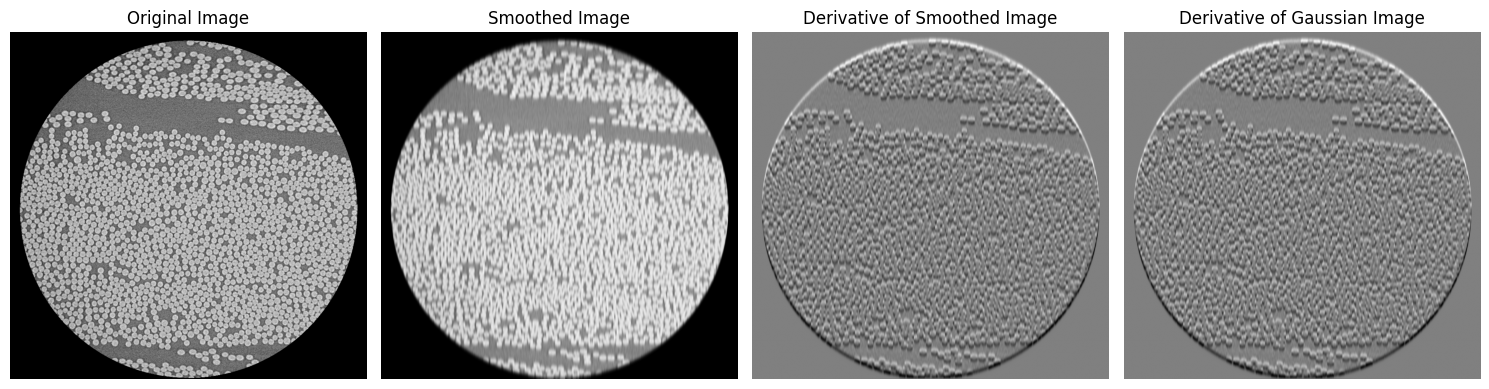

In [8]:
smoothed_image = convolve_columns(image, kernel_1D)

derivative_kernel = np.array([0.5, 0, -0.5])

# convolve the smoothed image with the derivative kernel
image_derivative = convolve_columns(smoothed_image, derivative_kernel)

# convolve the image with the derivative of gaussian kernel 

image_derivative_gaussian = convolve_columns(image, kernel_1D_grad)

difference_der_ker_vs_der_gauss = np.abs(image_derivative - image_derivative_gaussian)
avg_difference = difference_der_ker_vs_der_gauss.mean()

print(f"Average difference between the two methods: {avg_difference}")

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(smoothed_image, cmap='gray')
ax[1].set_title("Smoothed Image")
ax[1].axis('off')
ax[2].imshow(image_derivative, cmap='gray')
ax[2].set_title("Derivative of Smoothed Image")
ax[2].axis('off')
ax[3].imshow(image_derivative_gaussian, cmap='gray')
ax[3].set_title("Derivative of Gaussian Image")
ax[3].axis('off')
plt.tight_layout()
plt.show()




#### Verify that a convolution with a Gausssian of $t = 20$ is equal to ten convolutions with a Gaussian of $t = 2$.. Remember that $sigma = \sqrt(t)$. You can compare the two images by showing the difference image.

In [3]:
t_4 = 20. 
N_4 = 5.
# create the 1D kernel
kernel_1D_4 = create_1D_kernel_2(t_4, N_4)

# create 2D kernel by outer product of the 1D kernels
kernel_2d_4 = np.outer(kernel_1D_4, kernel_1D_4)

# convolve the image with the kernel
image_blurred_4 = convolve(image, kernel_2d_4, mode='reflect')

t_2 = 2 
kernel_1D_2 = create_1D_kernel_2(t_2, N_4)

# create 2D kernel by outer product of the 1D kernels
kernel_2d_2 = np.outer(kernel_1D_2, kernel_1D_2)

# Start with original image
image_2 = image.copy()

# Apply the convolution 10 times, using the result of each convolution as input for the next
for _ in range(10):
    image_2 = convolve(image_2, kernel_2d_2, mode='reflect')

difference_t_20_t2 = image_blurred_4 - image_2

dif = np.abs(image_blurred_4 - image_2).mean()
print(f"Average difference between the two methods: {dif}")


Sigma: 4.47213595499958
Sigma: 1.4142135623730951
Average difference between the two methods: 1.3665071060610451e-08


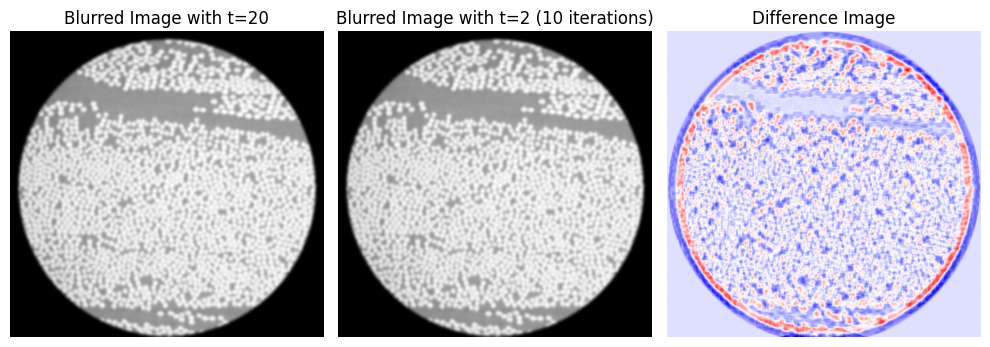

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image_blurred_4, cmap='gray')
ax[0].set_title("Blurred Image with t=20")
ax[0].axis('off')
ax[1].imshow(image_2, cmap='gray')
ax[1].set_title("Blurred Image with t=2 (10 iterations)")
ax[1].axis('off')
ax[2].imshow(difference_t_20_t2, cmap='bwr')
ax[2].set_title("Difference Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()

##### Verify that a convolution with a Gaussian derivative of $t = 20$ is equal to convolving with a Gaussian of $t = 10$ and a Gaussian derivative of $t = 10$. 

Sigma: 4.47213595499958
Sigma: 3.1622776601683795
Sigma: 3.1622776601683795
Average difference between the two methods: 0.02450713639954595


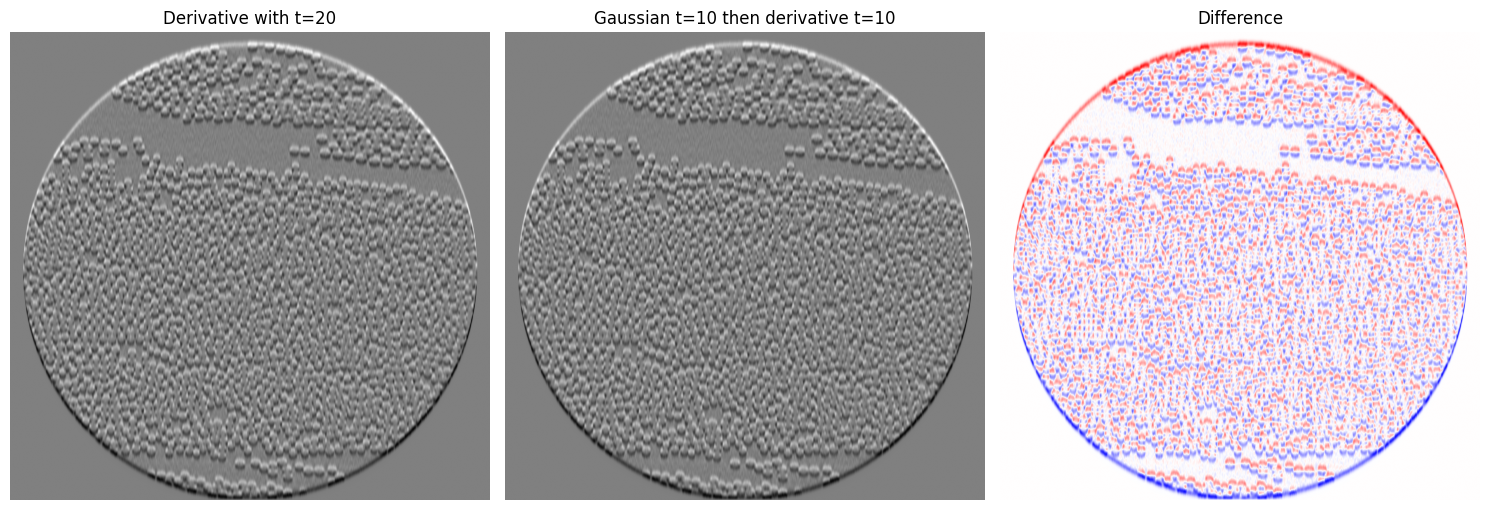

: 

In [ ]:
t = 20 
N = 5

# create the 1D gaussian derivative kernel for t=20
kernel_der_20 = create_1D_kernel_grad_2(t, N)

# convolve image with gaussian derivative t=20
image_der_20 = convolve(image, kernel_der_20.reshape(-1, 1))

# For t=10 operations
t_10 = 10

# create the 1D gaussian kernel for t=10
kernel_10 = create_1D_kernel_2(t_10, N)

# create the 1D gaussian derivative kernel for t=10
kernel_der_10 = create_1D_kernel_grad_2(t_10, N)

# First convolve with gaussian t=10
image_temp = convolve(image, kernel_10.reshape(-1, 1))

# Then convolve with gaussian derivative t=10
image_der_10 = convolve(image_temp, kernel_der_10.reshape(-1, 1))

# Compare the two methods
difference = np.abs(image_der_20 - image_der_10).mean()
print(f"Average difference between the two methods: {difference}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_der_20, cmap='gray')
ax[0].set_title("Derivative with t=20")
ax[0].axis('off')
ax[1].imshow(image_der_10, cmap='gray')
ax[1].set_title("Gaussian t=10 then derivative t=10")
ax[1].axis('off')
ax[2].imshow(image_der_20 - image_der_10, cmap='bwr')
ax[2].set_title("Difference")
ax[2].axis('off')

plt.tight_layout()
plt.show()
